In [13]:
import pandas as pd
import io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:

from google.colab import files
uploaded = files.upload()

def train_model():

    #df = pd.read_csv('latest_videos.csv')
    df = pd.read_csv(io.BytesIO(uploaded['latest_videos.csv']))
    df['text'] = df['Title'] + ' ' + df['Description']
    df = df.dropna(subset=['text'])

    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Political Affiliation'], test_size=0.2, random_state=42, stratify=df['Political Affiliation'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

    vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)

    X_train_len = pd.DataFrame([len(t) for t in X_train]).values
    X_val_len = pd.DataFrame([len(t) for t in X_val]).values
    X_test_len = pd.DataFrame([len(t) for t in X_test]).values

    scaler = StandardScaler()
    X_train_len = scaler.fit_transform(X_train_len)
    X_val_len = scaler.transform(X_val_len)
    X_test_len = scaler.transform(X_test_len)

    X_train_tfidf = hstack([X_train_tfidf, X_train_len])
    X_val_tfidf = hstack([X_val_tfidf, X_val_len])
    X_test_tfidf = hstack([X_test_tfidf, X_test_len])

    clf = svm.SVC(C=1000, gamma=0.001, kernel='rbf')
    clf.fit(X_train_tfidf, y_train)

    return clf, vectorizer, scaler, X_val_tfidf, y_val, X_test_tfidf, y_test

Saving latest_videos.csv to latest_videos.csv


In [16]:
def predict_political_affiliation(title, description, clf, vectorizer, scaler):
    text = title + ' ' + description
    text_tfidf = vectorizer.transform([text])
    text_len = pd.DataFrame([len(text)]).values
    text_len = scaler.transform(text_len)
    text_tfidf = hstack([text_tfidf, text_len])
    prediction = clf.predict(text_tfidf)
    return prediction[0]

##########################Validation set##########################
               precision    recall  f1-score   support

         Left       0.86      0.86      0.86       118
Non-political       0.92      0.96      0.94       228
        Right       0.88      0.79      0.83       118

     accuracy                           0.89       464
    macro avg       0.88      0.87      0.88       464
 weighted avg       0.89      0.89      0.89       464

##########################Test set##########################
               precision    recall  f1-score   support

         Left       0.91      0.84      0.87       118
Non-political       0.90      0.99      0.94       228
        Right       0.90      0.80      0.85       118

     accuracy                           0.90       464
    macro avg       0.90      0.88      0.89       464
 weighted avg       0.90      0.90      0.90       464



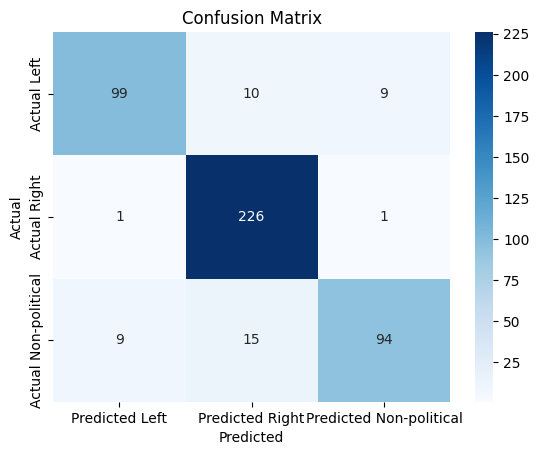

The political affiliation of the video 'Robert Shapiro reveals what OJ whispered after verdict' is predicted to be Non-political


In [17]:
if __name__ == '__main__':
    clf, vectorizer, scaler, X_val_tfidf, y_val, X_test_tfidf, y_test = train_model()

    print('##########################Validation set##########################')
    y_val_pred = clf.predict(X_val_tfidf)
    print(classification_report(y_val, y_val_pred))

    print('##########################Test set##########################')
    y_pred = clf.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual Left', 'Actual Right', 'Actual Non-political'], columns=['Predicted Left', 'Predicted Right', 'Predicted Non-political'])

    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    title = "Robert Shapiro reveals what OJ whispered after verdict"
    description = ""
    print(f"The political affiliation of the video '{title}' is predicted to be {predict_political_affiliation(title, description, clf, vectorizer, scaler)}")